In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [3]:
spx_path = "data/SPX_database_2010.xlsx"
df_tri = pd.read_excel(spx_path, sheet_name="total_ret").set_index("Dates")

df_sofr = pd.read_excel("./data/sofr.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"]) 
df_sofr = df_sofr.set_index("Dates").sort_index()
df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) -1
df_sofr

,Price,Taxa_diaria
Dates,,
2014-01-02,0.0005,0.000002
2014-01-03,0.0005,0.000002
2014-01-06,0.0005,0.000002
2014-01-07,0.0004,0.000002
2014-01-08,0.0004,0.000002
...,...,...
2025-07-28,0.0436,0.000169
2025-07-29,0.0436,0.000169
2025-07-30,0.0432,0.000168


In [4]:
# df_tri = df_tri[(df_tri.index.year >= 2000)]
df_sofr = df_sofr[(df_sofr.index.year >= 2000) ]
prices = df_tri.copy()
returns = prices.pct_change()

In [5]:
def _choose_30(tri_df, random_state=42):
    eligible = sorted(list(map(str, tri_df.columns)))
    rng = np.random.default_rng(random_state)
    chosen = rng.choice(eligible, size=min(30, len(eligible)), replace=False)
    return list(map(str, chosen))

tickers_30 = _choose_30(prices)
tickers_30[:5]

['MSI UN Equity.1',
 'K UN Equity.1',
 'GRMN UN Equity',
 'SW UN Equity.1',
 'AVGO UW Equity.1']

In [6]:
prices = prices[tickers_30]
returns = returns[tickers_30]
prices = df_tri.copy()
prices.index = pd.to_datetime(prices.index)
prices = prices.select_dtypes(include=[np.number]).dropna(how="all", axis=1)

## Are returns dependent on past information about returns?

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def acf1(x):
    return x.autocorr(lag=1)

def acf1_threshold(T):
    if T > 0:
        return 2.0 / np.sqrt(T)
    return np.nan

def ljung_box_pval(x, lag=20):
    x = x.dropna()
    if len(x) < lag + 5:
        return np.nan
    return acorr_ljungbox(x, lags=[lag], return_df=True)["lb_pvalue"].iloc[0]

rows = []
for t in returns.columns:
    x = returns[t].dropna()
    T = len(x)
    if T < 30:
        rows.append({
        	"ticker": t, "T": T, "acf1": np.nan, "acf1_thr": np.nan,
            "acf1_sig": False, "lb_pval_lag20": np.nan,
            "direction": "insufficient_data", "dependent?": "insufficient_data"
        })
        continue

    r1 = acf1(x)
    thr = acf1_threshold(T)
    signal = bool(abs(r1) > thr)
    p_lb = ljung_box_pval(x, lag=20)

    if signal:
        direction = "momentum" if r1 > 0 else "reversal"
    else:
        direction = "none"

    if signal or (not np.isnan(p_lb) and p_lb < 0.05):
        dep = "evidence_of_dependence"
    else:
        dep = "no_evidence"

    rows.append({
        "ticker": t,
        "T": T,
        "acf1": r1,
        "acf1_thr": thr,
        "acf1_sig": signal,
        "lb_pval_lag20": p_lb,
        "direction": direction,
        "dependent?": dep
    })

dependence_summary = pd.DataFrame(rows).set_index("ticker").sort_index()
dependence_summary

,T,acf1,acf1_thr,acf1_sig,lb_pval_lag20,direction,dependent?
ticker,,,,,,,
AVB UN Equity,4065,-0.040360,0.031369,True,4.451653e-11,reversal,evidence_of_dependence
AVGO UW Equity.1,4065,-0.060622,0.031369,True,2.441224e-08,reversal,evidence_of_dependence
AXON UW Equity,4065,-0.020358,0.031369,False,3.421301e-02,none,evidence_of_dependence
BLK UN Equity.1,4065,-0.049594,0.031369,True,3.041466e-09,reversal,evidence_of_dependence
CL UN Equity,4065,-0.097175,0.031369,True,4.304409e-18,reversal,evidence_of_dependence
CNP UN Equity,4065,-0.077711,0.031369,True,5.596279e-22,reversal,evidence_of_dependence
FFIV UW Equity,4065,-0.008022,0.031369,False,9.458424e-04,none,evidence_of_dependence
GEV UN Equity.1,352,-0.050739,0.106600,False,1.599478e-01,none,no_evidence
GRMN UN Equity,4065,0.001360,0.031369,False,1.000000e+00,none,no_evidence


In [10]:
def summarize_dependence(dep_df):
    df = dep_df.copy()
    total = len(df)
    dep = (df["dependent?"] == "evidence_of_dependence").sum()
    none = (df["dependent?"] == "no_evidence").sum()
    dir_counts = df["direction"].value_counts(dropna=False).to_dict()
    share = dep / total if total else float("nan")
    return {
        "n_stocks": total,
        "n_with_evidence": dep,
        "n_no_evidence": none,
        "share_with_evidence": share,
        "direction_counts": dir_counts
    }

summary_numbers = summarize_dependence(dependence_summary)
summary_numbers

{'n_stocks': 30,
 'n_with_evidence': np.int64(25),
 'n_no_evidence': np.int64(5),
 'share_with_evidence': np.float64(0.8333333333333334),
 'direction_counts': {'none': 17, 'reversal': 12, 'momentum': 1}}

## Are your stock prices random walks?

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

prices = prices[tickers].dropna(how="all").sort_index()
log_prices = np.log(prices.replace(0, np.nan)).dropna(how="all")

def _adf_p(y, regression="c"):
    y = y.dropna()
    if len(y) < 40: return np.nan
    return adfuller(y, autolag="AIC", regression=regression)[1]

def _kpss_p(y, regression="c"):
    y = y.dropna()
    if len(y) < 40: return np.nan
    try:
        return kpss(y, regression=regression, nlags="auto")[1]
    except Exception:
        return np.nan

def _lb_p_on_returns(x, lag=20):
    x = x.dropna()
    if len(x) < lag + 5: return np.nan
    return acorr_ljungbox(x, lags=[lag], return_df=True)["lb_pvalue"].iloc[0]

rows = []
for t in log_prices.columns:
    y = log_prices[t].dropna()
    x = returns[t].dropna()

    adf_c   = _adf_p(y, "c")
    adf_ct  = _adf_p(y, "ct")
    kpss_c  = _kpss_p(y, "c")
    kpss_ct = _kpss_p(y, "ct")

    lb_ret  = _lb_p_on_returns(x, lag=20)

    unitroot_votes = int((adf_c is not np.nan and adf_c >= 0.05 and kpss_c is not np.nan and kpss_c < 0.05) or
                         (adf_ct is not np.nan and adf_ct >= 0.05 and kpss_ct is not np.nan and kpss_ct < 0.05))
    stationary_votes = int((adf_c is not np.nan and adf_c < 0.05 and kpss_c is not np.nan and kpss_c >= 0.05) or
                           (adf_ct is not np.nan and adf_ct < 0.05 and kpss_ct is not np.nan and kpss_ct >= 0.05))

    if unitroot_votes and not stationary_votes:
        level_class = "unit_root"
    elif stationary_votes and not unitroot_votes:
        level_class = "stationary"
    else:
        level_class = "mixed_or_inconclusive"

    increments_iid = (not np.isnan(lb_ret)) and (lb_ret >= 0.05)

    if level_class == "unit_root" and increments_iid:
        rw_consistency = "consistent_with_random_walk"
    elif level_class == "unit_root" and not increments_iid:
        rw_consistency = "unit_root_but_dependent_increments"
    elif level_class == "stationary":
        rw_consistency = "not_random_walk"
    else:
        rw_consistency = "inconclusive"

    rows.append({
        "ticker": t,
        "adf_p_c": adf_c, "adf_p_ct": adf_ct,
        "kpss_p_c": kpss_c, "kpss_p_ct": kpss_ct,
        "levels_class": level_class,
        "lb_p_returns_lag20": lb_ret,
        "increments_white_noise?": bool(increments_iid) if not np.isnan(lb_ret) else np.nan,
        "random_walk_conclusion": rw_consistency
    })

rw_summary = pd.DataFrame(rows).set_index("ticker").sort_index()

panel_view = {
    "n_stocks": len(rw_summary),
    "unit_root_levels": int((rw_summary["levels_class"]=="unit_root").sum()),
    "stationary_levels": int((rw_summary["levels_class"]=="stationary").sum()),
    "mixed_or_inconclusive_levels": int((rw_summary["levels_class"]=="mixed_or_inconclusive").sum()),
    "increments_white_noise": int(rw_summary["increments_white_noise?"].fillna(False).sum()),
    "consistent_random_walk": int((rw_summary["random_walk_conclusion"]=="consistent_with_random_walk").sum()),
    "unit_root_but_dependent_increments": int((rw_summary["random_walk_conclusion"]=="unit_root_but_dependent_increments").sum())
}

rw_summary, panel_view

(                   adf_p_c  adf_p_ct  kpss_p_c  kpss_p_ct  \
 ticker                                                      
 AVB UN Equity     0.042573  0.011954  0.010000   0.010000   
 AVGO UW Equity.1  0.977427  0.384912  0.010000   0.010000   
 AXON UW Equity    0.965450  0.052541  0.010000   0.010000   
 BLK UN Equity.1   0.939124  0.012302  0.010000   0.010000   
 CL UN Equity      0.429481  0.207878  0.010000   0.010000   
 CNP UN Equity     0.543259  0.077455  0.010000   0.010000   
 FFIV UW Equity    0.245524  0.032498  0.010000   0.090751   
 GEV UN Equity.1   0.956208  0.417118  0.010000   0.010000   
 GRMN UN Equity    0.926687  0.560501  0.010000   0.010000   
 HAL UN Equity     0.082944  0.184692  0.010000   0.010000   
 HOLX UW Equity    0.507440  0.062146  0.010000   0.010000   
 HON UW Equity     0.092444  0.081750  0.010000   0.010000   
 IT UN Equity      0.427828  0.068910  0.010000   0.010000   
 JBL UN Equity.1   0.987612  0.659509  0.010000   0.010000   
 K UN Eq

In [13]:
tickers = [t for t in tickers_30 if t in prices.columns]
prices_30 = prices[tickers].dropna(how="all").sort_index()
rets_d = returns[tickers].dropna(how="all").sort_index()
month_end = prices_30.resample("M").last().ffill()
rets_m = month_end.pct_change().dropna(how="all")

logrets_d = np.log1p(rets_d).dropna(how="all")
logrets_m = np.log1p(rets_m).dropna(how="all")

def acf1(x: pd.Series):
    return x.autocorr(lag=1)

def acf1_sig(r1: float, T: int):
    if np.isnan(r1) or T <= 0: 
        return False
    thr = 2 / np.sqrt(T)
    return abs(r1) > thr, thr

def variance_ratio(log_ret: pd.Series, k: int):
    x = log_ret.dropna().values
    if len(x) < 5*k:
        return np.nan
    ksum = pd.Series(x).rolling(k).sum().dropna().values
    num = np.var(ksum, ddof=1)
    den = k * np.var(x, ddof=1)
    return num / den if den > 0 else np.nan

def classify_direction(acf_sig: bool, r1: float, vr_list: list):
    if acf_sig:
        return "momentum" if r1 > 0 else "reversal"
    vals = [v for v in vr_list if pd.notna(v)]
    if not vals:
        return "none"
    gt = sum(v > 1 for v in vals)
    lt = sum(v < 1 for v in vals)
    if gt > lt:
        return "momentum"
    if lt > gt:
        return "reversal"
    return "none"

def analyze_block(rets: pd.DataFrame, logrets: pd.DataFrame, vr_ks: list, label: str):
    rows = []
    for t in rets.columns:
        x = rets[t].dropna()
        T = len(x)
        if T < 30:
            rows.append({
                "ticker": t,
                f"acf1_{label}": np.nan,
                f"acf1_thr_{label}": np.nan,
                f"acf1_sig_{label}": False,
                **{f"VR_{label}_{k}": np.nan for k in vr_ks},
                f"signal_{label}": "insufficient_data"
            })
            continue
        r1 = acf1(x)
        sig, thr = acf1_sig(r1, T)
        vr_vals = {f"VR_{label}_{k}": variance_ratio(logrets[t], k) for k in vr_ks}
        direction = classify_direction(sig, r1, list(vr_vals.values()))
        rows.append({
            "ticker": t,
            f"acf1_{label}": r1,
            f"acf1_thr_{label}": thr,
            f"acf1_sig_{label}": sig,
            **vr_vals,
            f"signal_{label}": direction
        })
    return pd.DataFrame(rows).set_index("ticker")

daily = analyze_block(rets_d, logrets_d, vr_ks=[5, 21, 63], label="daily")
monthly = analyze_block(rets_m, logrets_m, vr_ks=[2, 6, 12], label="monthly")

momrev_summary = daily.join(monthly, how="outer")

def summarize_signals(df, col):
    counts = df[col].value_counts()
    n = len(df)
    return {
        "n": n,
        "momentum": int(counts.get("momentum", 0)),
        "reversal": int(counts.get("reversal", 0)),
        "none": int(counts.get("none", 0)),
        "insufficient_data": int(counts.get("insufficient_data", 0))
    }

panel_daily   = summarize_signals(momrev_summary, "signal_daily")
panel_monthly = summarize_signals(momrev_summary, "signal_monthly")

momrev_summary, panel_daily, panel_monthly

(                  acf1_daily  acf1_thr_daily  acf1_sig_daily  VR_daily_5  \
 ticker                                                                     
 AVB UN Equity      -0.040360        0.031369            True    0.937578   
 AVGO UW Equity.1   -0.060622        0.031369            True    0.894658   
 AXON UW Equity     -0.020358        0.031369           False    1.000755   
 BLK UN Equity.1    -0.049594        0.031369            True    0.900323   
 CL UN Equity       -0.097175        0.031369            True    0.818318   
 CNP UN Equity      -0.077711        0.031369            True    0.986810   
 FFIV UW Equity     -0.008022        0.031369           False    0.951591   
 GEV UN Equity.1    -0.050739        0.106600           False    0.727718   
 GRMN UN Equity      0.001360        0.031369           False    1.003787   
 HAL UN Equity       0.022049        0.031369           False    1.108489   
 HOLX UW Equity     -0.017439        0.031369           False    0.973550   

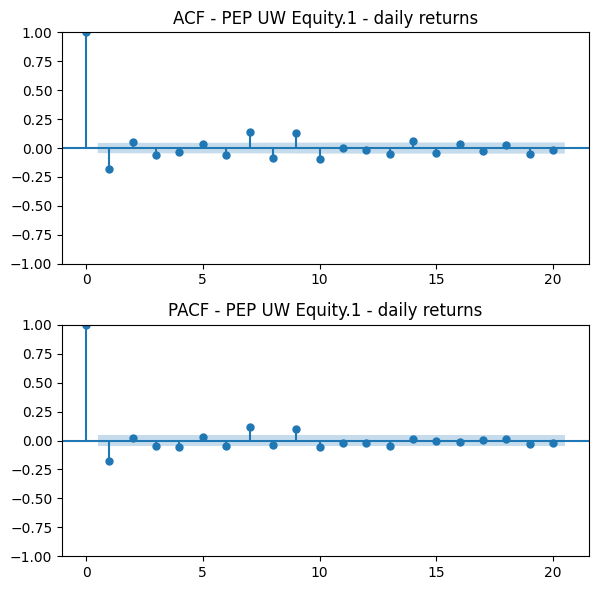

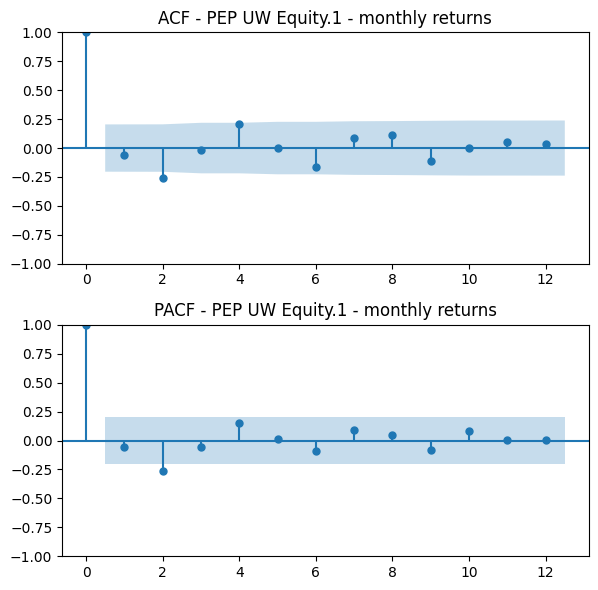

In [40]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

tickers = [t for t in tickers_30 if t in prices.columns]
prices_30 = prices[tickers].dropna(how="all").sort_index()

rets_d = returns[tickers].dropna(how="all").sort_index()
month_end = prices_30.resample("M").last().ffill()
rets_m = month_end.pct_change().dropna(how="all")
logp = np.log(prices_30.replace(0, np.nan)).dropna(how="all")

def acf_pacf(series, lags=20, title=""):
	x = series.dropna()
	fig, ax = plt.subplots(2, 1, figsize=(6, 6))
	plot_acf(x, lags=lags, alpha=0.05, ax=ax[0])
	ax[0].set_title(f"ACF - {title}")
	plot_pacf(x, lags=lags, alpha=0.05, method="ywm", ax=ax[1])
	ax[1].set_title(f"PACF - {title}")
	plt.tight_layout()
	plt.show()

def inspect_ticker(ticker, lags_daily=20, lags_monthly=12):
	acf_pacf(rets_d[ticker], lags=lags_daily, title=f"{ticker} - daily returns")
	acf_pacf(rets_m[ticker], lags=lags_monthly, title=f"{ticker} - monthly returns")

inspect_ticker(tickers[17])